# Fieldgen

In [ ]:
import mjd_fieldgen as mjd

In [ ]:
mjd.run_mjd_fieldgen(config_file="PPC.config", w=1, p=1)

# Calc signal

In [5]:
import mjd_fieldgen as mjd
import pandas as pd
import numpy as np
import ast
import os
import itertools 
import matplotlib.pyplot as plt
import math

# dir(mjd)

In [2]:
config_file_name = "PPC.config"
setup = mjd.MJD_Siggen_Setup()
mjd.signal_calc_init(config_file_name, setup)

0

In [3]:
def cyl_pt(r=0, phi=0, z=0):
    cpt = mjd.cyl_pt()
    cpt.r = r
    cpt.phi = phi
    cpt.z = z
    return cpt

def cart_pt(x=0, y=0, z=0):
    ptt = mjd.point()
    ptt.x = x
    ptt.y = y
    ptt.z = z
    return ptt

def cyl_to_cart(cpt):
    return cart_pt(x=cpt.r * math.cos(cpt.phi), 
              y=cpt.r * math.sin(cpt.phi), 
              z=cpt.z)

type(cyl_pt(r=5, phi=6, z=7))

mjd_fieldgen.cyl_pt

In [6]:
phis = 0
table = []
print(f"rmax={setup.xtal_radius}, zmax={setup.xtal_length}")
for rr, zz in itertools.product(range(0, int(setup.xtal_radius)), range(0, int(setup.xtal_length))):
    r = rr
    z = zz
    cpt = cyl_pt(r=r, phi=phis, z=z)
    
    try:
#         if efield_exists(pt, setup):
        if not mjd.outside_detector_cyl(cpt, setup):
            
            signal_out = mjd.run_get_signal(cyl_to_cart(cpt), setup)
            print(f"valid {cpt} {len(signal_out)} {'  '*20}", end="\r")
            table.append({"r": r, "z": z, "signal": list(signal_out)})
        else:
            print(f"validn't {cpt} {'  '*20}", end="\r")
            table.append({"r": r, "z": z, "signal": []})
    except AssertionError:
        print(f"validn't {cpt} {'  '*20}", end="\r")
        table.append({"r": r, "z": z, "signal": []})

rmax=33.5, zmax=51.599998474121094


In [18]:
df = pd.DataFrame(table)
df.to_csv("cache_01mm.csv", index=None)   # uncoment to save

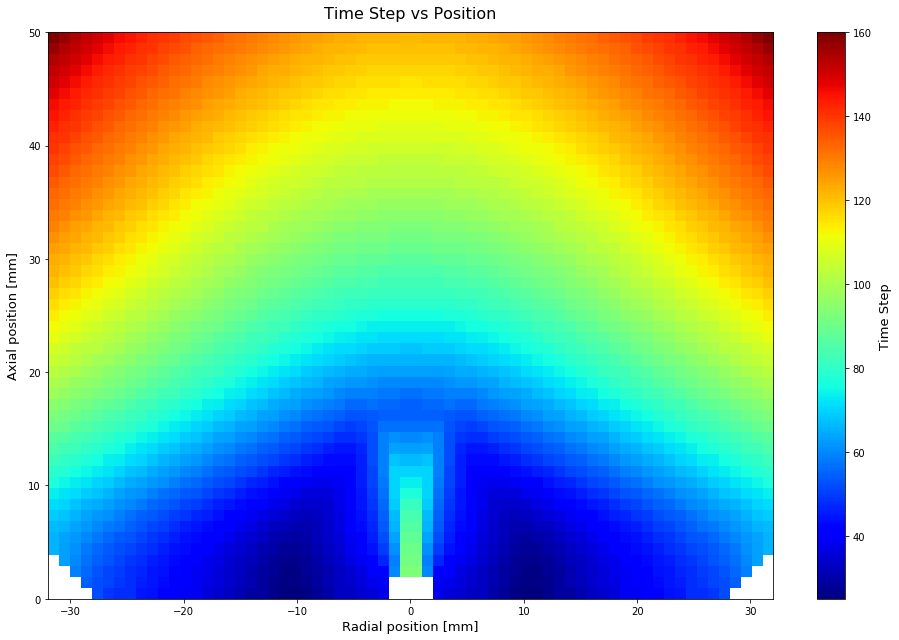

In [16]:
def mad_treshold(asd, treshold=0.8):
    if len(asd) > 0:
        try:
            asd = np.array(asd)
            maxx = max(asd)
            if maxx > treshold:
                return np.where(asd > maxx*0.99)[0][0]
            else:
                return np.nan # 200
        except IndexError:
            return np.nan  # 300
    else:
        return np.nan  # mask [] values to prevent from plotting
    
x = set(df['r'].values)
y = set(df['z'].values)
z = df['signal'].apply(mad_treshold).values
# now reshape the zvals array into the appropriate shape, and find the boundaries
zvals = z.reshape(len(x), len(y))

# imshow plots columns and rows opposite to how you'd expect; so transpose them
zvals = zvals.T
double = 1
if (double == 1 and min(x) == 0):
    # stack so we can plot the data from one half of the detector (positive r-values only)
    zvals_neg = np.fliplr(zvals)
    zvals_full = np.hstack((zvals_neg,zvals))
    bounds = (-1*max(x), max(x), min(y), max(y))
else:
    zvals_full = zvals
    bounds = (min(x), max(x), min(y), max(y))

fig = plt.figure(figsize=(16,9))
# plot the image
ip = plt.imshow(zvals_full,
#                 vmax=max_z,
                extent=bounds,   # set the boundaries of the edges of the 'image' data
                origin="lower",  # tell matplotlib where [0,0] is in the bottom
                cmap='jet')      # use the 'jet color map scheme, there are a bunch of options
                                 # see: https://matplotlib.org/examples/color/colormaps_reference.html
# label axes
plt.xlabel("Radial position [mm]", size=13)
plt.ylabel("Axial position [mm]", labelpad=8,  size=13)

# make the color legend
cbar = plt.colorbar(ip, fraction=0.046, pad=0.04)
cbar.set_label("Time Step", size=13, labelpad=8)
plt.title("Time Step vs Position\n", fontsize=16, linespacing=0.4)

plt.tight_layout()
plt.show()

In [22]:
pd.DataFrame(zvals_full).to_csv("cache_rise_01mm.csv", index=None)   # uncoment to save
pd.DataFrame(zvals_full)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,NaN,NaN,NaN,NaN,52.0,49.0,48.0,48.0,45.0,44.0,...,44.0,45.0,48.0,48.0,49.0,52.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,55.0,52.0,51.0,49.0,48.0,46.0,45.0,...,45.0,46.0,48.0,49.0,51.0,52.0,55.0,NaN,NaN,NaN
2,NaN,NaN,59.0,56.0,53.0,51.0,50.0,48.0,47.0,45.0,...,45.0,47.0,48.0,50.0,51.0,53.0,56.0,59.0,NaN,NaN
3,NaN,63.0,60.0,57.0,55.0,53.0,51.0,49.0,48.0,46.0,...,46.0,48.0,49.0,51.0,53.0,55.0,57.0,60.0,63.0,NaN
4,66.0,63.0,61.0,58.0,56.0,54.0,52.0,51.0,49.0,48.0,...,48.0,49.0,51.0,52.0,54.0,56.0,58.0,61.0,63.0,66.0
5,66.0,64.0,62.0,60.0,58.0,56.0,54.0,53.0,51.0,49.0,...,49.0,51.0,53.0,54.0,56.0,58.0,60.0,62.0,64.0,66.0
6,67.0,66.0,64.0,62.0,60.0,58.0,57.0,55.0,53.0,51.0,...,51.0,53.0,55.0,57.0,58.0,60.0,62.0,64.0,66.0,67.0
7,69.0,68.0,66.0,64.0,62.0,61.0,59.0,57.0,55.0,54.0,...,54.0,55.0,57.0,59.0,61.0,62.0,64.0,66.0,68.0,69.0
8,71.0,70.0,68.0,66.0,65.0,63.0,61.0,60.0,58.0,56.0,...,56.0,58.0,60.0,61.0,63.0,65.0,66.0,68.0,70.0,71.0
9,74.0,72.0,71.0,69.0,68.0,66.0,64.0,62.0,61.0,59.0,...,59.0,61.0,62.0,64.0,66.0,68.0,69.0,71.0,72.0,74.0


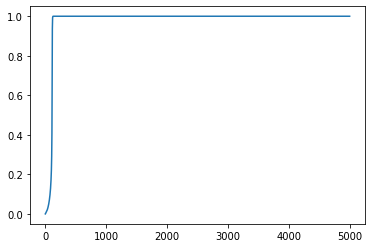

In [12]:
a = np.array(df['signal'][100])
# np.where(a > 0.5)[0][0]
plt.plot(a)

# Plot 3d

(r: -30.000000, phi: 1.000000, z: 10.000000)
(r: -29.000000, phi: 1.000000, z: 10.000000)
(r: -28.000000, phi: 1.000000, z: 10.000000)
(r: -27.000000, phi: 1.000000, z: 10.000000)
(r: -26.000000, phi: 1.000000, z: 10.000000)
(r: -25.000000, phi: 1.000000, z: 10.000000)
(r: -24.000000, phi: 1.000000, z: 10.000000)
(r: -23.000000, phi: 1.000000, z: 10.000000)
(r: -22.000000, phi: 1.000000, z: 10.000000)
(r: -21.000000, phi: 1.000000, z: 10.000000)
(r: -20.000000, phi: 1.000000, z: 10.000000)
(r: -19.000000, phi: 1.000000, z: 10.000000)
(r: -18.000000, phi: 1.000000, z: 10.000000)
(r: -17.000000, phi: 1.000000, z: 10.000000)
(r: -16.000000, phi: 1.000000, z: 10.000000)
(r: -15.000000, phi: 1.000000, z: 10.000000)
(r: -14.000000, phi: 1.000000, z: 10.000000)
(r: -13.000000, phi: 1.000000, z: 10.000000)
(r: -12.000000, phi: 1.000000, z: 10.000000)
(r: -11.000000, phi: 1.000000, z: 10.000000)
(r: -10.000000, phi: 1.000000, z: 10.000000)
(r: -9.000000, phi: 1.000000, z: 10.000000)
(r: -8.0000

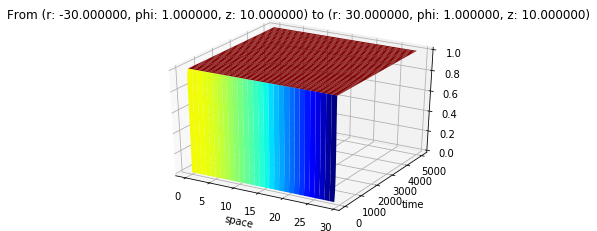

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import itertools 
import mjd_fieldgen as mjd
import math
# os.chdir(r"D:\Code_Base\ECL\mjd_siggen\py")

# config_file_name = "p1_new.config"
# config_file_name = "example.config"

config_file_name = "PPC.config"
setup = mjd.MJD_Siggen_Setup()
mjd.signal_calc_init(config_file_name, setup)

x = []
y = []
zz = []

rs = -30
phis = 1
zs = 10

rf = 30
phif = 1
zf = 10

for r in range(rs, rf, 1):
    pt = cyl_pt(r, phis, zs)
    print(pt)
    if mjd.efield_exists(pt, setup):
        pt = cyl_to_cart(pt)
        signal_out = mjd.run_get_signal(pt, setup)
        x += [r] # [z for z in range(100)]
        zz.append(list(signal_out)) 
    else:
        pass

x = np.array(x)
y = np.array([t for t in range(setup.time_steps_calc)])
zz = np.array(zz)
X, Y = np.meshgrid(x, y)


fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.contour3D(X.T, Y.T, zz, 50, cmap='binary')
ax.plot_surface(X.T, Y.T, zz, cmap='jet')  # , edgecolor='none'
# ax.plot_surface(np.array(x), np.array(y), np.array(zz) ,cmap='viridis', edgecolor='none')
# ax.plot_surface(x, y, zz ,cmap='viridis', edgecolor='none')
ax.set_title(f'From {cyl_pt(rs, phis, zs)} to {cyl_pt(rf, phif, zf)}')
plt.xlabel("space")
plt.ylabel("time")
plt.show()